# Cleaning

In this note book we check what data is missing data and look at outliers.  

We find that most stations have 1-2% of days of data missing, however Newtown has 10% data. A large proporition is Sat/Sun data from Feb to June of 2013. Major station work was undertaking in 2012 and the station reopend in Oct 29, 2012. It is possible the station was closed on the weekend though to June 2013 to complete the second stage of work.

We find there are a relatively small number of outliers that can be easily detected. We then create cleaned hourly data by replacing these outliers with values interpolated from the neightbours.  Finally we we create daily data for each station/date, from both the cleaned and uncleaned hourly data.

## The Data

This data is based on the train turnstile "validation" data from 2013 to June 2016 provided by Transport for NSW. It has transformed so there is an a single  observation for each Station, Date and Hour for the Exit and Entry figure. 

It includes:
* Station: The train station
* Hours:   5pm - 2am
* Date:    The date of the observation such that trips between 5pm and 2am the next day are the same date.
* Night:   THe name of the day for Date, e.g., "Friday".
* Exit:    The number of people exiting during the hour
* Entry:   The number of people entering during the hour

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 2)

import seaborn as sns
sns.set(font_scale=0.6)

import outlier
from utilities import *

In [2]:
df_hourly = pd.read_pickle("TrainValidationData/df_hourly.pkl")

In [3]:
print(list(df_hourly.Hour.cat.categories))
print(list(df_hourly.Night.cat.categories))
print(list(df_hourly.Station.cat.categories))

['5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', '12AM', '1AM', '2AM']
['Friday', 'Saturday', 'Sunday']
['Bondi Junction Station', 'Central Station', 'Circular Quay Station', 'Kings Cross Station', 'Martin Place Station', 'Museum Station', 'Newtown Station', 'North Sydney Station', 'Parramatta Station', 'St James Station', 'Town Hall Station']


# Missing data

In summary in this section we discover that:
1. Most stations are missing 1% to 2% of day however Newtown Station is missing 10% (40 days).
2. The missing data for Kings Cross and Parramatta is a few whole days on Saturday and probably due to the station being closed for station or trackwork.
3. The missing Newtown data is a combination of two factors. The the first 5 months of Saturdays from Feb-June 2013 are missing, which is probably the second stage of station upgrade works. There is also evidence that data is more likely to be missing later in the evening, possibly due to the gates being left open and people not swiping out.

In [4]:
daily = df_hourly.reset_index().pivot_table(index = 'Date', columns = ['Station'], values='Exit', aggfunc=sum)
print("Number of days", len(daily))
for station in daily.columns:
    print("{:>22}: {:}".format(station, daily[station].isnull().sum()))

Number of days 549
Bondi Junction Station: 11
       Central Station: 2
 Circular Quay Station: 13
   Kings Cross Station: 14
  Martin Place Station: 10
        Museum Station: 16
       Newtown Station: 58
  North Sydney Station: 12
    Parramatta Station: 6
      St James Station: 17
     Town Hall Station: 0


In the above we see number of days where there was no data for the entier period (7pm-1am). We see that: 
- Town Hall has no missing days and Centeral only 1 
- Paramatta is about 1% missing days
- All other except Newtown are around 2%
- Newtown is 10% and needs closers investigation

In [5]:
def missing_days(station, daily):
    for dt in daily[daily[station].isnull()].index:
        print(dt, dt.weekday_name)

In [6]:
missing_days('Kings Cross Station', daily)

2013-03-09 00:00:00 Saturday
2013-03-10 00:00:00 Sunday
2013-05-18 00:00:00 Saturday
2013-05-19 00:00:00 Sunday
2013-07-21 00:00:00 Sunday
2013-08-03 00:00:00 Saturday
2013-08-04 00:00:00 Sunday
2013-10-26 00:00:00 Saturday
2014-08-31 00:00:00 Sunday
2014-11-29 00:00:00 Saturday
2014-11-30 00:00:00 Sunday
2016-01-31 00:00:00 Sunday
2016-04-16 00:00:00 Saturday
2016-07-09 00:00:00 Saturday


In [7]:
missing_days('Parramatta Station', daily)

2013-03-16 00:00:00 Saturday
2013-03-17 00:00:00 Sunday
2013-05-05 00:00:00 Sunday
2013-11-16 00:00:00 Saturday
2013-11-17 00:00:00 Sunday
2014-04-06 00:00:00 Sunday


From this we see that Kings Cross and Parramatta are missing just a few Saturdays of data. This is likely to be station closures for works.

In [8]:
missing_days('Newtown Station', daily)

2013-02-02 00:00:00 Saturday
2013-02-03 00:00:00 Sunday
2013-02-09 00:00:00 Saturday
2013-02-10 00:00:00 Sunday
2013-02-16 00:00:00 Saturday
2013-02-17 00:00:00 Sunday
2013-02-23 00:00:00 Saturday
2013-02-24 00:00:00 Sunday
2013-03-02 00:00:00 Saturday
2013-03-09 00:00:00 Saturday
2013-03-10 00:00:00 Sunday
2013-03-16 00:00:00 Saturday
2013-03-17 00:00:00 Sunday
2013-03-23 00:00:00 Saturday
2013-03-24 00:00:00 Sunday
2013-03-29 00:00:00 Friday
2013-03-30 00:00:00 Saturday
2013-03-31 00:00:00 Sunday
2013-04-06 00:00:00 Saturday
2013-04-07 00:00:00 Sunday
2013-04-13 00:00:00 Saturday
2013-04-14 00:00:00 Sunday
2013-04-20 00:00:00 Saturday
2013-04-21 00:00:00 Sunday
2013-04-27 00:00:00 Saturday
2013-04-28 00:00:00 Sunday
2013-05-04 00:00:00 Saturday
2013-05-05 00:00:00 Sunday
2013-05-11 00:00:00 Saturday
2013-05-12 00:00:00 Sunday
2013-05-18 00:00:00 Saturday
2013-06-22 00:00:00 Saturday
2013-06-23 00:00:00 Sunday
2013-06-29 00:00:00 Saturday
2013-06-30 00:00:00 Sunday
2013-07-13 00:00:00

This has a long run of Saturdays (Feb - June 2013) are missing. Major station work was undertaking in 2012 and the station reopend in Oct 29, 2012. It is possible the station was closed on the weekend though to June 2013 to complete the second stage of work. 

## Missing Data By Hour

For shows some stations (Central, Kings Cross, Paramatter) the missing data does not change over time, implying that the entire day is missing. For others, the count of missing data increases later at night indicating that the station closes early or the gates are left open and people do not swipe off. 

In [9]:
(df_hourly.reset_index().pivot_table(index = 'Date', columns = ['Station', 'Hour'], values='Exit', aggfunc=sum).
             isnull().
             sum().reset_index().
             pivot('Station', 'Hour', 0))

Hour,5PM,6PM,7PM,8PM,9PM,10PM,11PM,12AM,1AM,2AM
Station,,,,,,,,,,
Bondi Junction Station,25,23,26,29,26,61,69,61,187,498
Central Station,2,2,2,2,2,5,6,6,6,33
Circular Quay Station,27,27,27,30,30,33,32,20,214,528
Kings Cross Station,27,26,28,29,29,30,29,23,134,499
Martin Place Station,21,22,24,23,25,62,92,142,272,525
Museum Station,32,36,36,35,36,119,118,127,290,536
Newtown Station,93,92,96,112,111,178,197,184,319,470
North Sydney Station,29,28,26,30,29,29,30,21,132,491
Parramatta Station,15,12,15,13,18,19,20,15,76,403


# Outliers

In this section we look for outliers, using the IQR method, and replace them using interpolation to create cleaned hourly data.

The following trellis plot has Stations from left to right and Nights from top to bottom. Each plot shows: 
- The Exit volumes drawn as a solid blue line with the date as the x-axis.
- A a trend line (linear regression) drawn in green.
- Outliers ([IQR Method](http://colingorrie.github.io/outlier-detection.html)) highlighted as read stars.
- The date of the introduction of the lockout law is a vertical, grey dotted line.

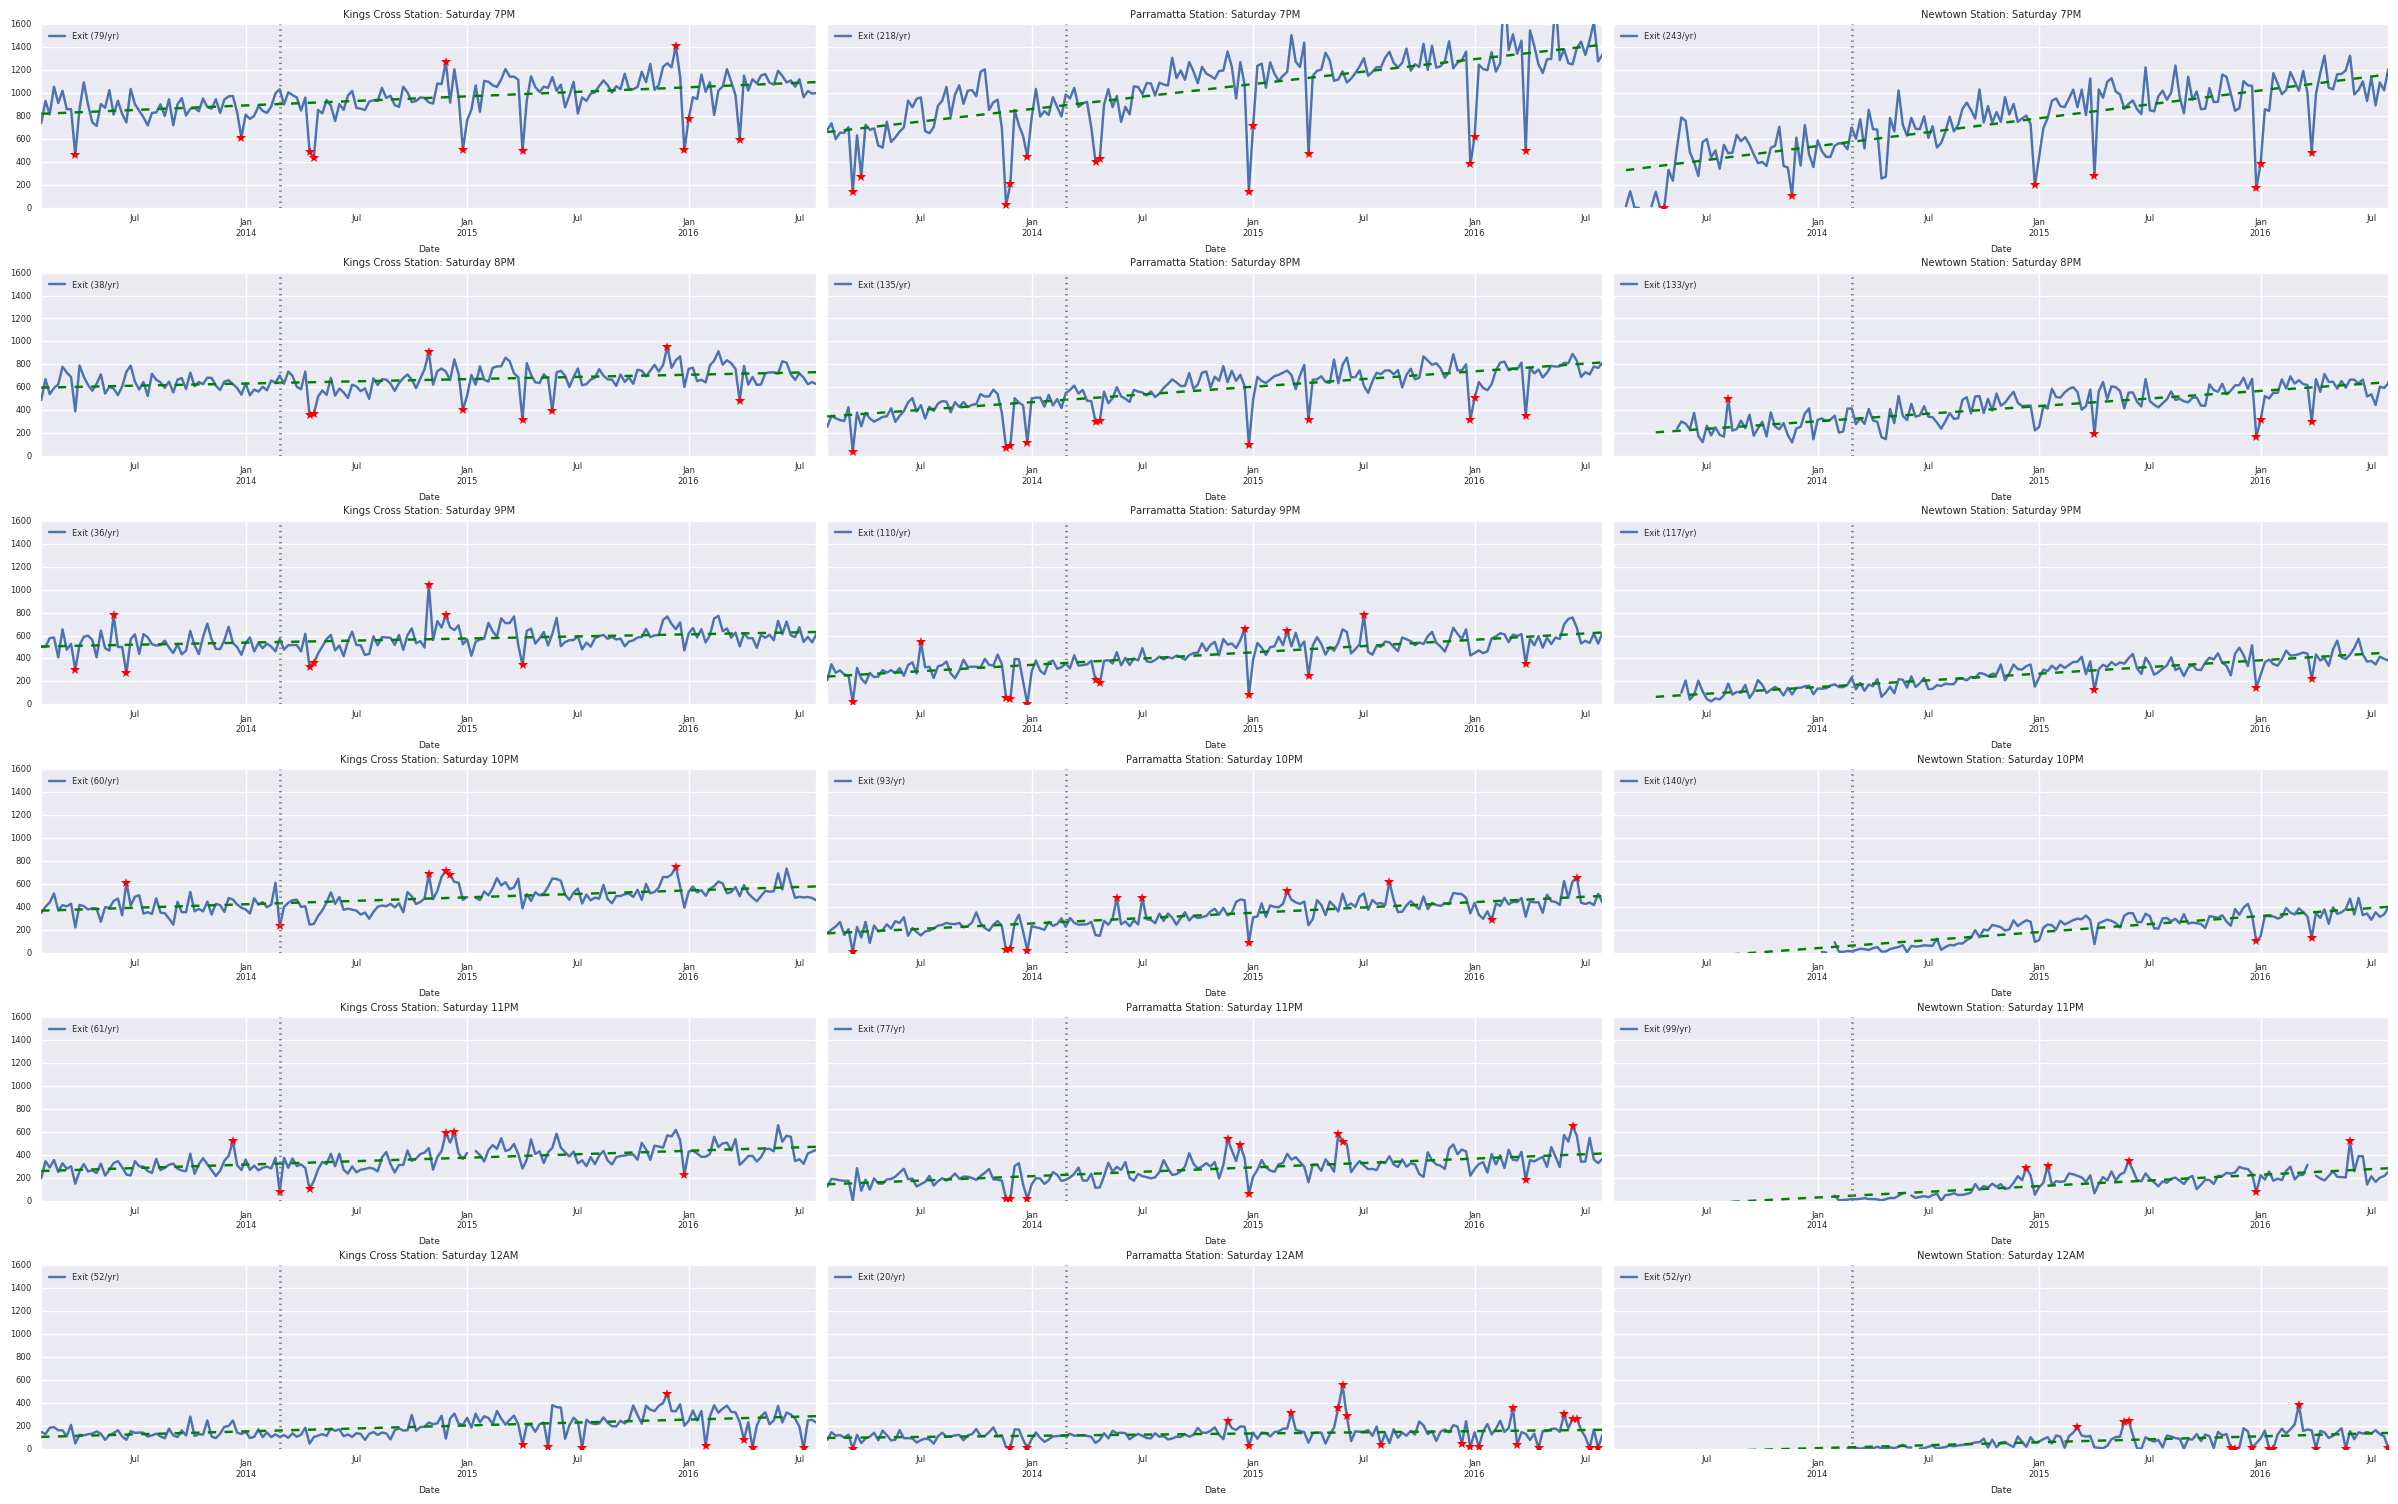

In [10]:
plot_stations_hourly(df_hourly,["Kings Cross Station", "Parramatta Station", 'Newtown Station'])

This chart indicates a number of interesting things.
* While there are outliers, there are only 3-4 per year. 
* Generally the Exit volumes increase over the years. 
* There is considerable variation from week to week (20-30%)
* There isn't a noticable change around the lockout law date.

However we can see that the data looks OK. We clean the hourly data by replacing outliers with interpolated values from the neighboring data. 

In [11]:
df_hourly_cleaned = (df_hourly.set_index(['Station', 'Night', 'Hour'], append=True).
                        groupby(level=['Station', 'Night', 'Hour'], as_index=False).
                        transform(outlier.replace, how='linear').
                        reset_index(level=['Station', 'Night', 'Hour']))
assert len(df_hourly) == len(df_hourly_cleaned), "Length of cleaned data is incorrect"

In [12]:
df_hourly_cleaned.to_pickle("TrainValidationData/df_hourly_cleaned.pkl")

# Daily summaries

From the hourly and cleaned hourly data, we create daily and cleaned daily that sums the Exit/Entry data from 7PM - 2AM. We limit to this period to avoid the commuter data

In [14]:
df_daily = (df_hourly[df_hourly.Hour >= "7PM" ].
                reset_index().
                groupby(['Station', 'Night', 'Date'], as_index=False).
                agg({'Exit':sum, "Entry":sum}).
                set_index('Date'))

assert len(df_daily) == len(df_hourly)/len(df_hourly.Hour.cat.categories), "Wrong length"
assert df_daily.index.min() == df_hourly.index.min(), "Wrong start dates"
assert df_daily.index.max() == df_hourly.index.max(), "Wrong end dates"

df_daily.to_pickle("TrainValidationData/df_daily.pkl")

In [15]:
df_daily_cleaned = (df_hourly_cleaned[df_hourly_cleaned.Hour >= "7PM" ].
                        reset_index().
                        groupby(['Station', 'Night', 'Date'], as_index=False).
                        agg({'Exit':sum, "Entry":sum}).
                        set_index('Date'))

assert len(df_daily_cleaned) == len(df_hourly)/len(df_hourly.Hour.cat.categories), "Wrong length"

assert df_daily_cleaned.index.min() == df_hourly.index.min(), "Wrong start dates"
assert df_daily_cleaned.index.max() == df_hourly.index.max(), "Wrong end dates"

df_daily_cleaned.to_pickle("TrainValidationData/df_daily_cleaned.pkl")

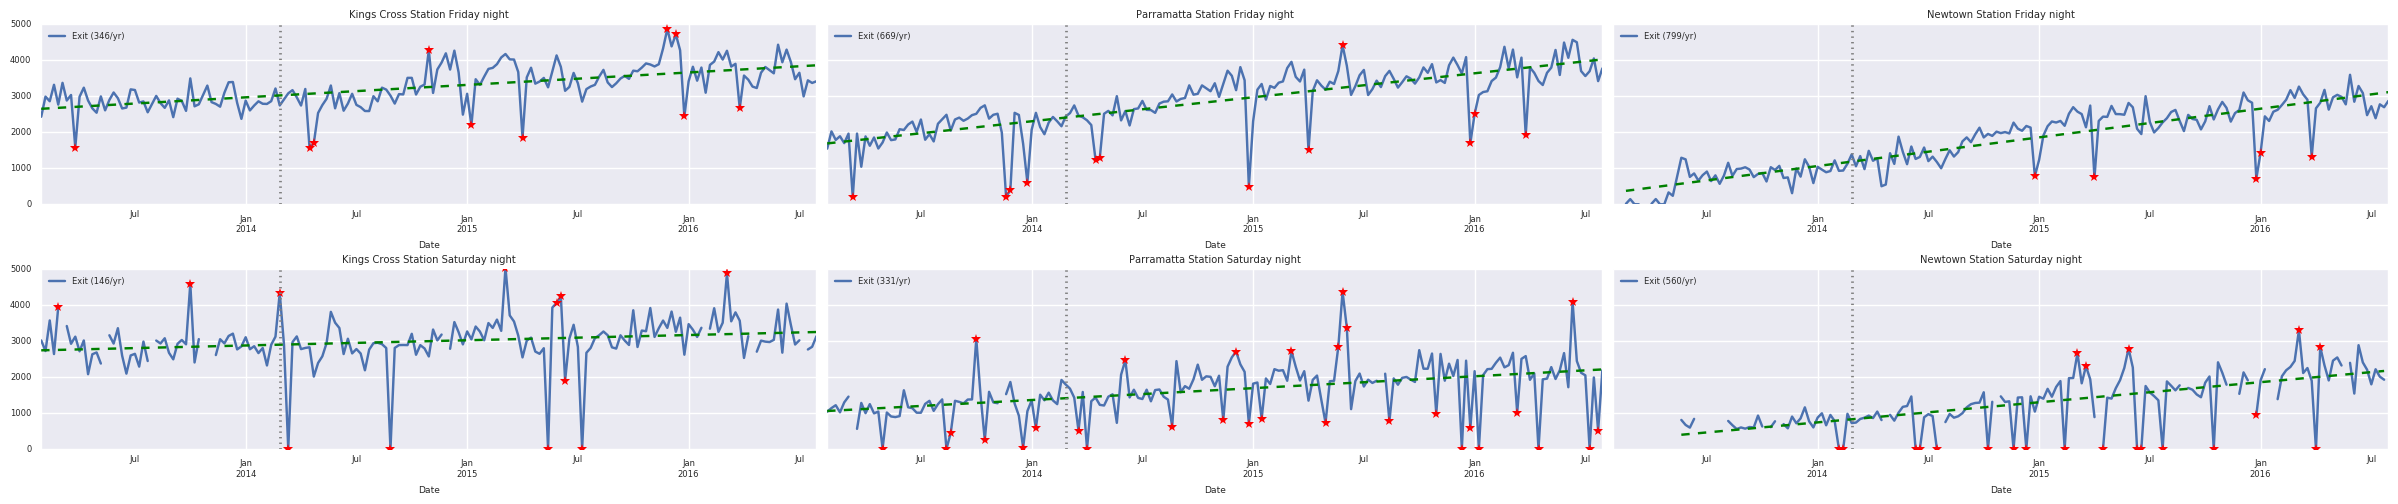

In [16]:
plot_stations_daily(df_daily,["Kings Cross Station", "Parramatta Station", 'Newtown Station'])

The trellis plot above of the uncleaned daily data shows:
- There are still 2-4 outliers per year.
- Saturday data has more outliers, especiall Parramatta and Newtown.
- There are a number of zeros in the Sunday daily data
- Not the Newtown Data on Saturday is largely missing for the first 6 months

This trellis plot below of the cleaned daily data (which is based on cleaning the hourly data) shows far fewer outliers and no zeros. 

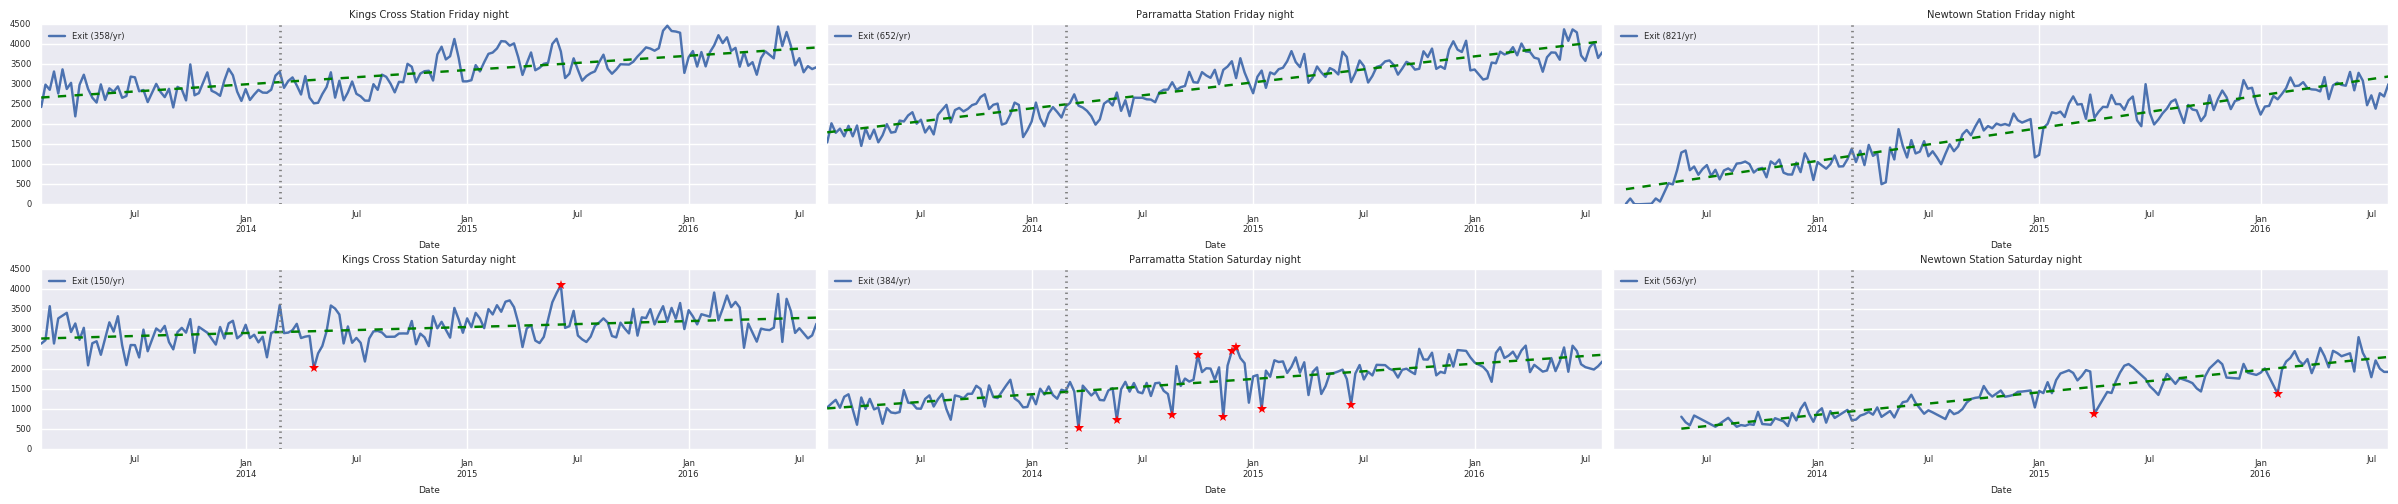

In [17]:
plot_stations_daily(df_daily_cleaned,["Kings Cross Station", "Parramatta Station", 'Newtown Station'])